In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 

In [34]:
df = pd.read_parquet('../data/cleaned/weather.parquet')
df['time'] = pd.to_datetime(df['time'])
df.isna().sum()

time                             0
temperature                      0
relative_humidity                0
dew_point                        0
precipitation (mm)               0
rain (mm)                        0
snowfall (cm)                    0
pressure_msl (hPa)               0
surface_pressure (hPa)           0
cloud_cover (%)                  0
cloud_cover_low (%)              0
cloud_cover_mid (%)              0
cloud_cover_high (%)             0
vapour_pressure_deficit (kPa)    0
wind_speed_10m (km/h)            0
wind_direction                   0
is_Day                           0
dtype: int64

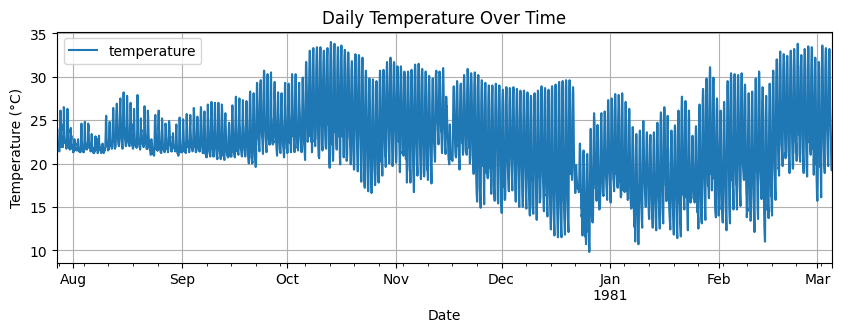

In [35]:
df[5000:10300].plot(x='time', y='temperature', kind='line', figsize=(10,3))
plt.title('Daily Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.grid()
plt.show()

In [36]:
df['time'] = pd.to_datetime(df['time'])
# Ensure the 'time' column is set as the DataFrame time for time-based operations
df.set_index('time', inplace=True)

# Calculate the difference with the value from 24 hours ago
df['temperature_diff_24h'] = df['temperature'] - df['temperature'].shift(freq='24h')

# Reset time if needed for further processing
df.reset_index(inplace=True)
# df[85:100]
df = df.dropna().reset_index(drop=True)

df.drop(columns=['snowfall (cm)'], inplace=True)

## Stationarity Analysis

In [37]:
# ## Stationarity Analysis
# from statsmodels.tsa.stattools import adfuller, kpss
# import warnings
# warnings.filterwarnings('ignore')

# def stationarity_analysis(df, dataset_name, column_name = None):
#     """
#     column_name: specify the column to analyze, default is 'Close'
#     Perform ADF and KPSS tests for stationarity analysis
#     """
#     data = df['Close'] if column_name is None else df[column_name]
    
#     data.dropna(inplace=True)  # Drop NaN values for accurate testing
    
#     print(f"\n{'='*50}")
#     print(f"STATIONARITY ANALYSIS: {dataset_name.upper()}")
#     print(f"{'='*50}")
    
#     # ADF Test
#     print("\n--- AUGMENTED DICKEY-FULLER TEST ---")
#     adf_result = adfuller(data, autolag='AIC')
#     print(f"ADF Statistic: {adf_result[0]:.6f}")
#     print(f"p-value: {adf_result[1]:.6f}")
#     print("Critical Values:")
#     for key, value in adf_result[4].items():
#         print(f"\t{key}: {value:.6f}")
    
#     if adf_result[1] <= 0.05:
#         print("ADF Result: STATIONARY (Reject null hypothesis)")
#     else:
#         print("ADF Result: NON-STATIONARY (Fail to reject null hypothesis)")
    
#     # KPSS Test
#     print("\n--- KWIATKOWSKI-PHILLIPS-SCHMIDT-SHIN TEST ---")
#     kpss_result = kpss(data, regression='c', nlags='auto')
#     print(f"KPSS Statistic: {kpss_result[0]:.6f}")
#     print(f"p-value: {kpss_result[1]:.6f}")
#     print("Critical Values:")
#     for key, value in kpss_result[3].items():
#         print(f"\t{key}: {value:.6f}")
    
#     if kpss_result[1] <= 0.05:
#         print("KPSS Result: NON-STATIONARY (Reject null hypothesis)")
#     else:
#         print("KPSS Result: STATIONARY (Fail to reject null hypothesis)")
    
#     # Combined interpretation
#     print("\n--- COMBINED INTERPRETATION ---")
#     adf_stationary = adf_result[1] <= 0.05
#     kpss_stationary = kpss_result[1] > 0.05
    
#     if adf_stationary and kpss_stationary:
#         print("CONCLUSION: Series is STATIONARY")
#     elif not adf_stationary and not kpss_stationary:
#         print("CONCLUSION: Series is NON-STATIONARY")
#     else:
#         print("CONCLUSION: Results are INCONCLUSIVE - further investigation needed")

# stationarity_analysis(df=df, dataset_name="temperature_Raws", column_name='temperature')
# stationarity_analysis(df=df, dataset_name="temperature_diff_24h", column_name='temperature_diff_24h')

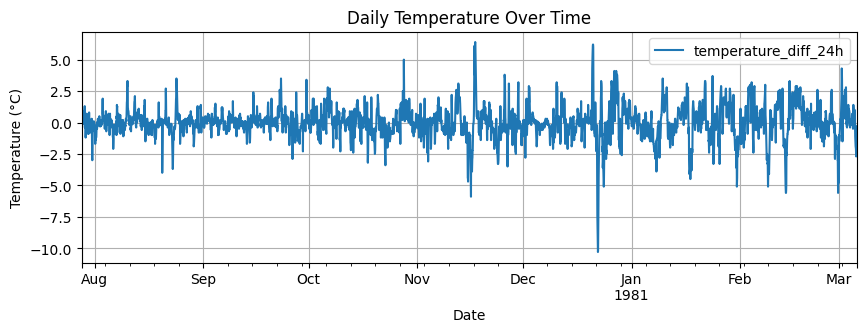

In [38]:
df[5000:10300].plot(x='time', y='temperature_diff_24h', kind='line', figsize=(10,3))
plt.title('Daily Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.grid()
plt.show()

In [39]:
mean_lr = df['temperature_diff_24h'].mean()
std_lr = df['temperature_diff_24h'].std()
CLAMP_STD = 3

upper = mean_lr + CLAMP_STD * std_lr
lower = mean_lr - CLAMP_STD * std_lr

df['temperature_diff_24h'] = np.where(df['temperature_diff_24h'] > upper, upper,
                        np.where(df['temperature_diff_24h'] < lower, lower, df['temperature_diff_24h']))

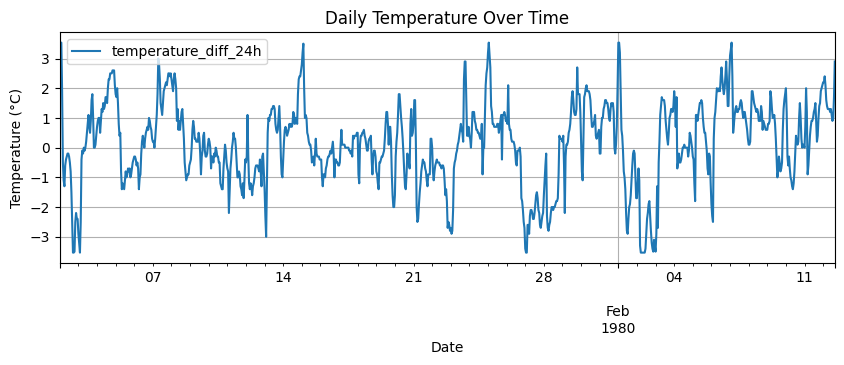

In [40]:
df[0:1000].plot(x='time', y='temperature_diff_24h', kind='line', figsize=(10,3))
plt.title('Daily Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.grid()
plt.show()

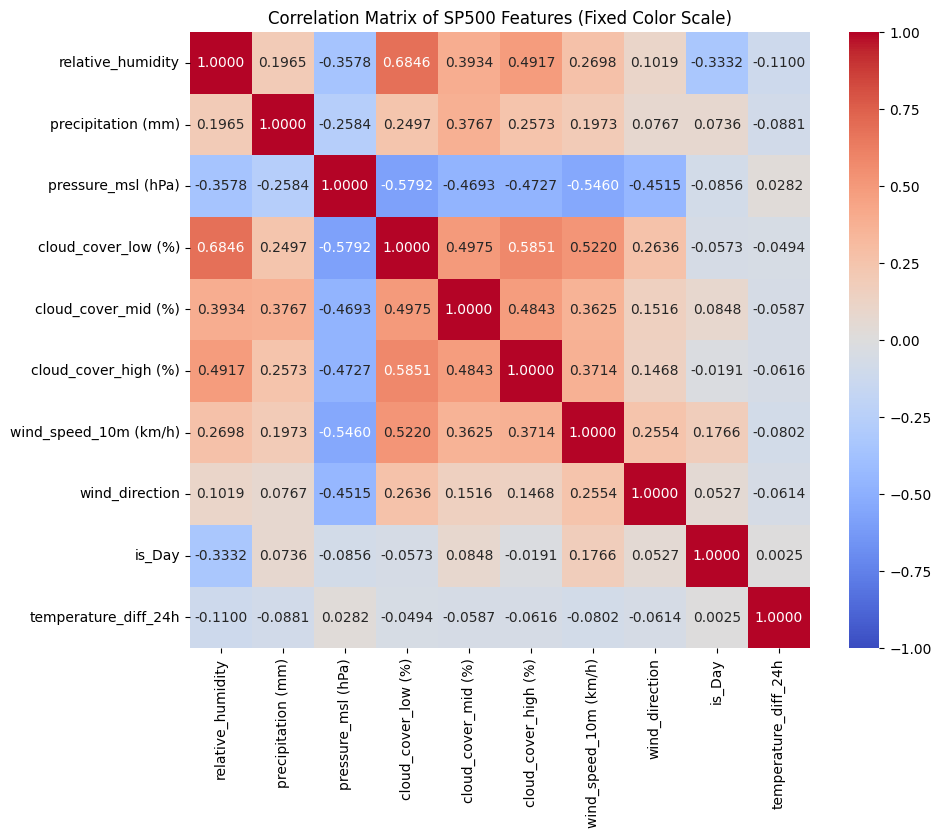

In [41]:
highly_correlated_features = ['vapour_pressure_deficit (kPa)', 'dew_point', 'rain (mm)', 'surface_pressure (hPa)', 'cloud_cover (%)']
# highly_correlated_features = []
dfcorr = df.drop(columns=['time', 'temperature']+highly_correlated_features)

# Set vmin and vmax to fix the color scale between -1 and 1
plt.figure(figsize=(10, 8))
sns.heatmap(dfcorr.corr(), annot=True, fmt=".4f", cmap='coolwarm', cbar=True, vmin=-1, vmax=1)
plt.title('Correlation Matrix of SP500 Features (Fixed Color Scale)')
plt.savefig('../report/plots/weather_correlation_matrix_fixed_scale.pdf')
plt.show()

In [42]:
dfcorr.columns

Index(['relative_humidity', 'precipitation (mm)', 'pressure_msl (hPa)',
       'cloud_cover_low (%)', 'cloud_cover_mid (%)', 'cloud_cover_high (%)',
       'wind_speed_10m (km/h)', 'wind_direction', 'is_Day',
       'temperature_diff_24h'],
      dtype='object')

In [ ]:
# Step 3: Data Preparation (No global scaling; features exclude Date and LogRet)
features = ['relative_humidity', 'precipitation (mm)', 'pressure_msl (hPa)',
       'cloud_cover_low (%)', 'cloud_cover_mid (%)', 'cloud_cover_high (%)',
       'wind_speed_10m (km/h)', 'wind_direction', 'is_Day', 'temperature_diff_24h']
X = df[features].values
y = df['temperature_diff_24h'].shift(-1).dropna().values  # Next LogRet; len N-1
X = X[:-1]  # Align; assume df sorted by Date

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit  # For guidance, but implementing custom rolling for financial data
torch.manual_seed(42)

# Step 1: Define Elman RNN Model
class ElmanRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(ElmanRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, nonlinearity='tanh')
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# Step 2: Custom Dataset for Sequences
class TimeSeriesDataset(Dataset):
    def __init__(self, data, targets, seq_len=10):
        self.data = data
        self.targets = targets
        self.seq_len = seq_len
    
    def __len__(self):
        return len(self.data) - self.seq_len
    
    def __getitem__(self, idx):
        x = self.data[idx:idx + self.seq_len]
        y = self.targets[idx + self.seq_len]
        return torch.FloatTensor(x), torch.FloatTensor([y])

class JordanRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        """
        Jordan RNN Model. The num_layers parameter is kept for API consistency
        but this implementation uses a single hidden layer.
        """
        super(JordanRNN, self).__init__()
        self.hidden_size = hidden_size
        
        # The RNN cell takes the input and the combined hidden+previous_output state
        self.rnn_cell = nn.RNNCell(input_size + output_size, hidden_size)
        
        # Fully connected layer to produce the output
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Get batch size and sequence length
        batch_size = x.size(0)
        seq_len = x.size(1)
        
        # Initialize hidden state and output for the first time step
        hidden = torch.zeros(batch_size, self.hidden_size).to(x.device)
        prev_output = torch.zeros(batch_size, self.fc.out_features).to(x.device)

        # Manually loop through each time step in the sequence
        for t in range(seq_len):
            # Concatenate current input with the previous time step's output
            combined_input = torch.cat((x[:, t, :], prev_output), dim=1)
            
            # Update the hidden state
            hidden = self.rnn_cell(combined_input, hidden)
            
            # The output for this step is based on the new hidden state
            prev_output = self.fc(hidden)
            
        # The final output is the output from the last time step
        return prev_output
    
class MultiRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        """
        Multi-Recurrent Neural Network (MultiRNN) - Combination of Elman and Jordan RNNs
        
        This network feeds back both:
        1. Previous hidden state (like Elman RNN)
        2. Previous output (like Jordan RNN)
        
        Args:
            input_size: Number of input features
            hidden_size: Number of hidden units
            output_size: Number of output features
            num_layers: Number of layers (kept for API consistency, uses single layer)
        """
        super(MultiRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # The RNN cell takes input + previous_hidden + previous_output
        # Input concatenation: [current_input, prev_hidden, prev_output]
        self.rnn_cell = nn.RNNCell(input_size + hidden_size + output_size, hidden_size)
        
        # Fully connected layer to produce the output
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        Forward pass through the MultiRNN
        
        Args:
            x: Input tensor of shape (batch_size, seq_len, input_size)
            
        Returns:
            Output tensor of shape (batch_size, output_size)
        """
        # Get batch size and sequence length
        batch_size = x.size(0)
        seq_len = x.size(1)
        
        # Initialize hidden state and output for the first time step
        hidden = torch.zeros(batch_size, self.hidden_size).to(x.device)
        prev_output = torch.zeros(batch_size, self.output_size).to(x.device)

        # Manually loop through each time step in the sequence
        for t in range(seq_len):
            # Concatenate current input, previous hidden state, and previous output
            # This is the key difference: we use BOTH prev_hidden and prev_output
            combined_input = torch.cat((x[:, t, :], hidden, prev_output), dim=1)
            
            # Update the hidden state using the combined input
            hidden = self.rnn_cell(combined_input, hidden)
            
            # Calculate the current output based on the new hidden state
            current_output = self.fc(hidden)
            
            # Update prev_output for the next time step
            prev_output = current_output
            
        # Return the final output (output from the last time step)
        return current_output
